## Assignment for Module 4, Training Models

In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

### Fix the categories in the categorical variable

In [2]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [3]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [4]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [5]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# ASSIGNMENT

Using the familiar California housing dataset (target = 'median_house_value'), train several models using various regularization techniques to improve model accuracy. 

### 1.1 Partition into train and test

Use `train_test_split` from `sklearn.model_selection` to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [7]:
from sklearn.model_selection import train_test_split
target_col = 'median_house_value'

train_set,test_set = train_test_split(housing, train_size=0.7) #70% training, 30% testing

x_train = train_set.drop(target_col, axis =1)
y_train = train_set[target_col].copy()

x_test = test_set.drop(target_col, axis =1)
y_test = test_set[target_col].copy()

### 1.2 Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2) #DEGREE 2

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)
x_test_poly.shape

(6193, 136)

##### You should obtain X_train and X_test with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$.

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [9]:
print("Original number of features: "+str(len(x_train.columns)))
print("Final number of features: "+str(x_train_poly.shape[1]))

Original number of features: 15
Final number of features: 136


### 1.3 Scaling features

Similarly, use `StandardScaler` from `sklearn.preprocessing` to normalize the training and testing data, using the training data

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_poly_scaled = scaler.fit_transform(x_train_poly) #train the scaler using the training data
x_test_poly_scaled = scaler.transform(x_test_poly)

#### Comparing models

Use this function to display your cross val scores, or you may use your own custom function.

**Either way it is important to display your results as you train new models.**

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 2.1 Linear regression on original features (no transformations) --- benchmark

Train a simple linear regression model using `cross_val_score` with no regularization or feature transformations. This model will serve as your benchmark.

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear_regression_notrans = LinearRegression()
score_linear_regression_notrans = cross_val_score(linear_regression_notrans, x_train, y_train, cv=4)
display_scores(score_linear_regression_notrans)

Scores: [0.62969052 0.67288998 0.63548198 0.63018465]
Mean: 0.6420617851774064


### 2.2 Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in **2.1** but with the original and transformed features (136 features)

In [160]:
linear_regression_trans = LinearRegression()
score_linear_regression = cross_val_score(linear_regression_trans, x_train_poly_scaled, y_train, cv=4)
display_scores(score_linear_regression)

Scores: [-1.09515330e+20 -5.12976415e+00  7.05787816e-01 -5.00479077e+18]
Mean: -2.8630030305576415e+19


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 2.3 Ridge regression

Using the same transformed dataset from **2.2**, train another linear model but this time apply L2 regularization. Run the model through grid search to find the optimal regularization hyperparams. Print the results. 

In [183]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import GridSearchCV

ridge_regression = Ridge()
alphas = np.logspace(0,4,base=10,num=100)
parameters = {'alpha':alphas}
ridge_cv = GridSearchCV(ridge_regression,parameters, cv=4, n_jobs=4, verbose=4)
ridge_cv.fit(x_train_poly_scaled, y_train);

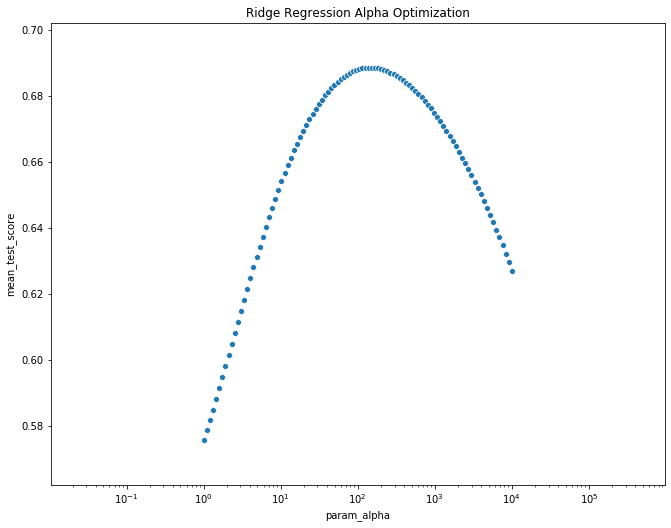

In [184]:
import matplotlib.pyplot as plt
import seaborn
ridge_scores = pd.DataFrame.from_dict(ridge_cv.cv_results_)
f,ax = plt.subplots(figsize=(11,8.5))
ax.set(xscale="log")
splot=seaborn.scatterplot(x="param_alpha",y="mean_test_score",data=ridge_scores)
ax.set(title="Ridge Regression Alpha Optimization");

In [186]:
ridge_regression_optimal = ridge_cv.best_estimator_
score_ridge_regression = cross_val_score(ridge_regression_optimal,x_train_poly_scaled, y_train, cv=4)
display_scores(score_ridge_regression)
ridge_regression_optimal

Scores: [0.66527456 0.71676072 0.68360691 0.68844831]
Mean: 0.688522624021745


### 2.4 Lasso regression

Now do the same as in **2.3** but with Lasso

### 2.4 Lasso regression

Now do the same as in **2.3** but with Lasso

In [243]:
from sklearn.linear_model import Lasso
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

lasso_regression = Lasso()
alphas = np.logspace(0,4,base=10,num=100)
parameters = {'alpha':alphas}
lasso_cv = GridSearchCV(lasso_regression,parameters, cv=4, n_jobs=4, verbose=4)
lasso_cv.fit(x_train_poly_scaled, y_train);

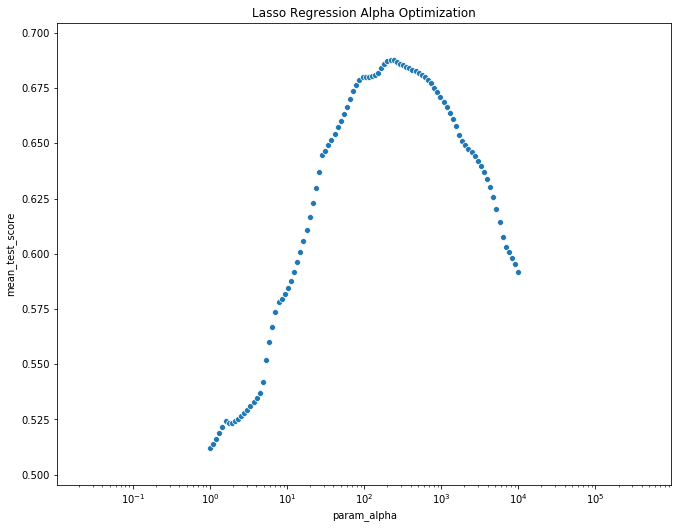

In [244]:
lasso_scores = pd.DataFrame.from_dict(lasso_cv.cv_results_)
f,ax = plt.subplots(figsize=(11,8.5))
ax.set(xscale="log")
splot=seaborn.scatterplot(x="param_alpha",y="mean_test_score",data=lasso_scores)
ax.set(title="Lasso Regression Alpha Optimization");

In [245]:
lasso_regression_optimal = lasso_cv.best_estimator_
score_lasso_regression = cross_val_score(lasso_regression_optimal,x_train_poly_scaled, y_train, cv=4)
display_scores(score_lasso_regression)
lasso_regression_optimal

Scores: [0.6690259  0.71486271 0.68136721 0.68593131]
Mean: 0.6877967828803938


Lasso(alpha=220.51307399030458, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### 2.5 Elastic Net regression

Do the same as in **2.3** and **2.4**, but now with Elastic Net. However, the grid search should be over the parameters alpha and  L1 ratio. Use just 3 values for L1 ratio.

In [262]:
from sklearn.linear_model import ElasticNet

elasticnet_regression = ElasticNet()
alphas = np.logspace(-2.5,1.5,base=10,num=30)
l1_ratios = np.array([0.2,0.5,0.8])

parameters = {'alpha':alphas, 'l1_ratio':l1_ratios}
elasticnet_cv = GridSearchCV(elasticnet_regression,parameters, cv=4,n_jobs=4,verbose=4)
elasticnet_cv.fit(x_train_poly_scaled, y_train);

Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  6.6min finished


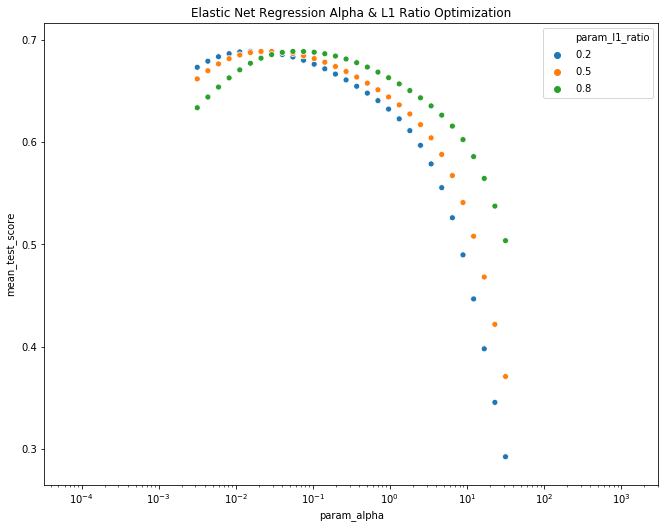

In [265]:
elasticnet_scores = pd.DataFrame.from_dict(elasticnet_cv.cv_results_)
elasticnet_scores["param_l1_ratio"] = ["$%s$" % x for x in elasticnet_scores["param_l1_ratio"]] #workaround for seaborn issue 1653
f,ax = plt.subplots(figsize=(11,8.5))
ax.set(xscale="log")
splot=seaborn.scatterplot(data=elasticnet_scores,x='param_alpha',y="mean_test_score",hue="param_l1_ratio")
ax.set(title="Elastic Net Regression Alpha & L1 Ratio Optimization");

In [266]:
elasticnet_regression_optimal = elasticnet_cv.best_estimator_
score_elasticnet_regression = cross_val_score(elasticnet_regression_optimal,x_train_poly_scaled, y_train, cv=4)
display_scores(score_elasticnet_regression)
elasticnet_regression_optimal

Scores: [0.66526023 0.71686383 0.68373025 0.68823776]
Mean: 0.6885230147006356


ElasticNet(alpha=0.015475873545578892, copy_X=True, fit_intercept=True,
           l1_ratio=0.2, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

### 3.1  Expected Results

Before you compute the final_rmse on the test data using your best model, pause and reflect:
- Does your best model have high variance? 
- Why was your best performing model better than the others?
- What is your expected rmse score on your test data? 

##### YOUR ANSWER HERE 

### 3.2. Evaluating your best model on TESTING data

Of the models you created above, choose the best one to test on the test set.

In [269]:
from sklearn.metrics import mean_squared_error

models = [(linear_regression_trans, score_linear_regression.mean()),
          (ridge_cv.best_estimator_,ridge_cv.best_score_),
          (lasso_cv.best_estimator_, lasso_cv.best_score_),
          (elasticnet_cv.best_estimator_,elasticnet_cv.best_score_)]

best_model = max(models,key=lambda item:item[1])[0]

y_predict = best_model.predict(x_test_poly_scaled)

final_mse = mean_squared_error(y_test, y_predict)
final_rmse = np.sqrt(final_mse)
print(final_rmse)
best_model

92027.99293983718


ElasticNet(alpha=0.015475873545578892, copy_X=True, fit_intercept=True,
           l1_ratio=0.2, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

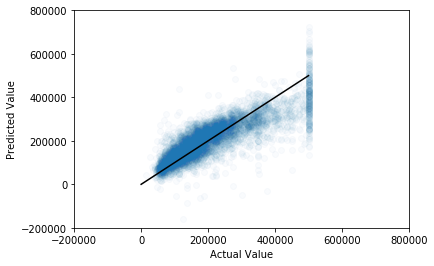

In [271]:
# Plot the results
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predict, alpha=0.025) # swap 'YOUR_PREDICTIONS' with the prediction values your model produces
plt.xlim([-200000,800000])
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.ylim([-200000,800000])
plt.plot([0,500000],[0,500000],color='k',linestyle='-')
plt.show()

### 4.1 Try a more advanced model

Try a more complex algorithm (SVR, RandomForest, etc.) and see if the accuracy improves (train on the full training set, and then test on the full test set). We have already done this in one of the earlier assignments so this should be easy!

Why does the accuracy improve when using a more complex algorithm in this case? Write a very breif answer in the cell below following your code.

In [ ]:
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import GridSearchCV

sv_regression = SVR()
Cs = np.logspace(5,9,base=10,num=5)
#Cs = np.array([10,100,1000,10000])
epsilons = np.array([0.01,0.1,1])
parameters = {'C':Cs,'epsilon':epsilons}

sv_cv = GridSearchCV(sv_regression,parameters,cv=2,n_jobs=4,verbose=4)
sv_cv.fit(x_train_poly_scaled, y_train);

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [22]:
sv_cv.cv_results_

{'mean_fit_time': array([23.85483348, 23.89131594, 30.61499834, 30.31817591, 30.86582017,
        31.15465295, 28.06792355, 27.84605098, 28.48768127, 28.23182523,
        25.93538094, 25.90940571, 25.99710488, 25.93464434, 18.35698032]),
 'std_fit_time': array([0.02148807, 0.05497026, 0.18489504, 0.17490065, 0.24536037,
        0.23536646, 0.16290617, 0.01798868, 0.01799095, 0.11093414,
        0.01049376, 0.01948619, 0.00498772, 0.35429895, 0.09144902]),
 'mean_score_time': array([23.01231682, 22.94835532, 27.25788832, 27.08598673, 26.23796976,
        25.85269237, 24.57342339, 24.91373086, 23.09727013, 22.76346195,
        22.82761717, 22.79013479, 22.21177495, 22.16230321, 14.55566251]),
 'std_score_time': array([0.06646025, 0.05946338, 0.26034951, 0.02048981, 0.28183639,
        0.0974443 , 0.14042139, 0.18589115, 0.08744967, 0.13442028,
        0.01399302, 0.15840852, 0.09644711, 0.07295799, 0.02798212]),
 'param_C': masked_array(data=[10.0, 10.0, 10.0, 100.0, 100.0, 100.0, 1000.0

##### YOUR ANSWER HERE 

# BONUS QUESTIONS

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



#[Optional]
Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?



#[Optional]
Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?



#[Optional]
Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?



#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3

